In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
blue, green, red = sns.color_palette()[:3]

%matplotlib inline

This notebook is an overview of the data that will be used throughout the project:

1. The classification target variable
2. The variables explaining and justifying the classification target variable
3. The features that will be used to train the binary classifier models

These data are stored in a SQLite database:

In [2]:
# Connect to the database
DB_PATH = '../resources/capstone_db.sqlite'
db = sqlite3.connect(DB_PATH)

# Get a cursor
cursor = db.cursor()

# 1. The classification target variable

The classification target variable is represented by the `koi_disposition` feature : 

In [3]:
# Load the classification target variable
query = '''
SELECT 
    kepoi_name,
    koi_disposition
FROM
    kois_activity_table;
'''
df = pd.read_sql_query(query, db)
print('KOIs Activity Table Shape:', df.shape)
df.head()

KOIs Activity Table Shape: (7732, 2)


,kepoi_name,koi_disposition
0,K00752.01,CONFIRMED
1,K00752.02,CONFIRMED
2,K00753.01,CANDIDATE
3,K00754.01,FALSE POSITIVE
4,K00755.01,CONFIRMED


There are three classes:

* Confirmed exoplanet TCEs (CONFIRMED)
* False positive TCEs (FALSE POSITIVE)
* Candidate TCEs (CANDIDATE)

The models will be trained with the false positive and confirmed exoplanets TCEs only. The candidates will be assessed by the best models of each types. The candidates predicted as exoplanet by the best classifier will be reclassify as strong candidate.

How is the labels distribution ? Will the training dataset be balanced ?

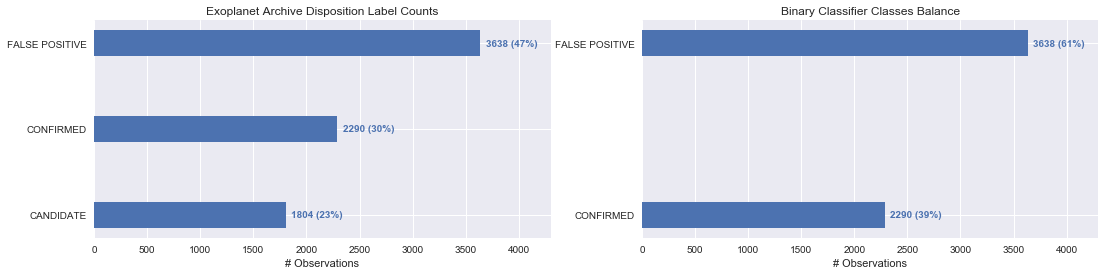

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))

# plot the classification target variable labels counts and normalized counts
x = pd.DataFrame({'counts': df.koi_disposition.value_counts(), 'counts %': df.koi_disposition.value_counts(normalize=True)})

ax[0].barh(np.arange(x.shape[0]), x.iloc[:, 0], tick_label=x.index, height=0.3)
for i in range(x.shape[0]):
    text = str(x.iloc[i, 0]) + ' (' + str(int(np.round(x.iloc[i, 1] * 100))) + '%)'
    ax[0].text(x=x.iloc[i, 0] + 50, y=i, s=text, va='center', color=blue, fontweight='bold')
ax[0].set_title('Exoplanet Archive Disposition Label Counts')
ax[0].set_xlabel('# Observations')
ax[0].invert_yaxis()
ax[0].set_xlim(0, 4300)

# plot the balance of the classes used to train models (FALSE POSITIVE & CONFIRMED only)
filter = df.koi_disposition != 'CANDIDATE' 
x = pd.DataFrame({'counts': df.koi_disposition[filter].value_counts(), 'counts %': df.koi_disposition[filter].value_counts(normalize=True)})

ax[1].barh(np.arange(x.shape[0]), x.iloc[:, 0], tick_label=x.index, height=0.15)
for i in range(x.shape[0]):
    text = str(x.iloc[i, 0]) + ' (' + str(int(np.round(x.iloc[i, 1] * 100))) + '%)'
    ax[1].text(x=x.iloc[i, 0] + 50, y=i, s=text, va='center', color=blue, fontweight='bold')
ax[1].set_title('Binary Classifier Classes Balance')
ax[1].set_xlabel('# Observations')
ax[1].invert_yaxis()
ax[1].set_xlim(0, 4300)

plt.show()

About 20% of our data are candidates to assess and there are a majority of false positive TCEs. Concerning the training of our binary classifiers, we will have to deal with an imbalance of 60%/40% between the false positive (negative class) and the confirmed exoplanet TCEs (positive class) respectively.

There are many strategies to deal with classes imbalance like upsampling the minority class or downsampling the majorty class. In this project, we will instead penalize the algoritms by applying weights to each class according to their frequency.

# 2. The variables explaining the classification target variable

From the KOIs activity table, we have extracted variables explaining and justifying the classification target variable:

In [5]:
# Load the KOIs Activity Table 
query = '''
SELECT
    kepoi_name,
    koi_disposition,
    koi_pdisposition,
    koi_score,
    koi_fpflag_nt,
    koi_fpflag_ss,
    koi_fpflag_co,
    koi_fpflag_ec,
    koi_comment
FROM
    kois_activity_table;
'''
df = pd.read_sql_query(query, db)
print('KOIs Activity Table Shape:', df.shape)
df.head()

KOIs Activity Table Shape: (7732, 9)


,kepoi_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_comment
0,K00752.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,NO_COMMENT
1,K00752.02,CONFIRMED,CANDIDATE,0.969,0,0,0,0,NO_COMMENT
2,K00753.01,CANDIDATE,CANDIDATE,0.000,0,0,0,0,DEEP_V_SHAPED
3,K00754.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,MOD_ODDEVEN_DV---MOD_ODDEVEN_ALT---DEEP_V_SHAPED
4,K00755.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,NO_COMMENT


There are two classification variables:

1. The Exoplanet Archive Disposition variable (`koi_disposition`), our classification target variable.
2. The Disposition Using the Kepler Data variable (`koi_pdisposition`), the classification issued from the Kepler pipeline

The Exoplanet Archive Disposition variable is in fact the Disposition Using Kepler Data variable enriched with the known exoplanets coming from the Exoplanet Archive Confirmed Planet table. The Disposition Using Kepler Data variable has only two classes, CANDIDATE and FALSE POSITIVE, attributed according to the test results obtained during the Kepler pipeline. 

All the other variables describe the Disposition Using Kepler Data classification variable. They explain the attribution of the false positive class. Absence of comment and/or false positive flags mean that the observation can't be rejected as a false positive, so becomes a candidate. The score variable is the level of confidence of this classification, false positives must have scores near 0 and candidates scores near 1.

In this project, we profit the knowledge of the confirmed exoplanets and our goal is to use this knowledge to revisit the candidate list to identify the strongest ones among them. This wish and hope is only possible if we are able to train our model with the following data:

* A list of confirmed exoplanets
* A list of "confirmed" false positives

These variables, except the classification target variable, will not be used to train the models because they would totally biased them. Hovewer, they will be used extensively during the data cleaning and exploratory data analysis steps. We want to keep only the TCEs for which we have high confidence they are confirmed exoplanets or confirmed false positives. 

It's worth mentioning the meaning of the 4 false positive flags:

* **Not Transit-Like Flag**  (`koi_fpflag_nt`)  
A KOI whose light curve is not consistent with that of a transiting planet.  
This includes, but is not limited to, instrumental artifacts, non-eclipsing variable stars, and spurious (very low SNR) detections.

* **Stellar Eclipse Flag** (`koi_fpflag_ss`)  
A KOI that is observed to have a significant secondary event, transit shape, or out-of-eclipse variability, which indicates that the transit-like event is most likely caused by an eclipsing binary. However, self-luminous, hot Jupiters with a visible secondary eclipse will also have this flag set, but with a disposition of PC.

* **Centroid Offset Flag** (`koi_fpflag_co`)  
The source of the signal is from a nearby star, as inferred by measuring the centroid location of the image both in and out of transit, or by the strength of the transit signal in the target's outer (halo) pixels as compared to the transit signal from the pixels in the optimal (or core) aperture.

* **Ephemeris Match Indicates Contamination Flag** (`koi_fpflag_ec`)  
The KOI shares the same period and epoch as another object and is judged to be the result of flux contamination in the aperture or electronic crosstalk.

The `kepoi_name` variable identify uniquely each TCEs.

# 3. The features

The features have been extracted from the Kepler Data Validation FITS files.

They can be grouped in different themes:

* Stellar properties
* Stellar magnitudes
* Stellar location and motion
* Transit parameters
* Transit pipeline statistics

Here is a sample of the stellar properties:

In [6]:
# Load the stellar properties
query = '''
SELECT *
FROM
    stellar_properties;
'''
df = pd.read_sql_query(query, db)
df.head()

,kepid,teff,logg,feh,radius,ebminusv,av,numtces,quarters
0,010797460,5850.0,4.426,0.14,1.040,0.142,0.441,2,11111111111111111000000000000000
1,010811496,5853.0,4.544,-0.18,0.868,0.120,0.373,1,11111101110111011000000000000000
2,010848459,5795.0,4.546,-0.52,0.803,0.122,0.378,1,11111110111011101000000000000000
3,010854555,6031.0,4.438,0.07,1.046,0.142,0.440,1,01111111111111111000000000000000
4,010872983,6046.0,4.486,-0.08,0.972,0.168,0.522,3,01111101110111011000000000000000


Predicting the nature of a TCE by just looking at its hosting star is for sure a weak and naive approach. We dont expect these features to be strong predictors. Moreover, the Kepler mission was to monitor stars similar to our Sun, so our dataset contains probably no giant and dwarf stars. However, it's not impossible that the star population represented in our dataset present already some patterns that could improve our predictions by few percents.

These features explain in order the following star properties:

* the star identifier (`kepid`)
* the effective temperature
* the surface gravity
* the metallicity
* the star radius in solar radii
* the reddenining
* the extinction

The `numtces` variable indicates the number of TCEs registred around the star. The `quarters` variable is a bit string indicating the quarters during which the star has been monitored. The four and half year of mission duration is represented by 17 quarter bits. Stars can have missing quarters of data.

The transit parameters should be our strongest predictors. These high-level features have been extracted from the light curves by the transit planet search (TPS) and data validation (DV) Kepler pipeline modules. Here is a sample of these data: 

In [7]:
# Load the transit parameters
query = '''
SELECT *
FROM
    transit_parameters;
'''
df = pd.read_sql_query(query, db)
df.head()

,kepoi_name,tperiod,tdepth,tdur,indur,impact,inclin,drratio,radratio,pradius
0,K00752.01,9.488028,630.381630,3.418783,0.659365,0.934177,84.169681,9.196221,0.028956,2.929099
1,K00752.02,54.418374,893.123959,4.585753,0.257789,0.711630,89.395301,67.428761,0.029346,2.968514
2,K00753.01,19.899143,10630.409762,1.776158,0.888079,0.929919,89.029114,54.880784,0.129501,12.266182
3,K00754.01,1.736955,7874.849223,2.341290,1.170645,0.933470,74.673384,3.531577,0.108508,9.365962
4,K00755.01,2.525622,578.297482,1.624692,0.070214,0.690533,85.604302,9.009601,0.023557,2.688826


where the features are in order:

* the transit period
* the transit depth
* the transit duration
* the ingress duration
* the impact
* the orbital inclination
* the ratio of planet distance to star radius 
* the ratio of planet radius to star radius
* the planet radius in earth radii

The magnitudes, location and motion features are expected to be weak predictors and will be studied during the EDA. The pipeline statistic features are out of the scope of this project but it's worth mentioning the signal-to-noise ratio and maximum multi-event statistics that will be used during the data cleaning and EDA steps.